In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def fetch_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("Error fetching data:", response.status_code, response.text)
        return None
    data = response.json()
    if 'results' not in data:
        print("No 'results' key in response:", data)
        return None
    return data

def calculate_daily_returns(df):
    df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

def update_outliers_list(current_df, historical_outliers_df, n=10):
    combined_df = pd.concat([historical_outliers_df, current_df])
    updated_outliers_df = combined_df.nlargest(n, 'abs_daily_return')
    updated_historical_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'historical']
    updated_real_time_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'test']
    return updated_historical_outliers_df, updated_real_time_outliers_df

def convert_timestamps(df):
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    return df

# API key and endpoints
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'
historical_url = f'https://api.polygon.io/v2/aggs/ticker/C:USDEUR/range/1/day/2023-01-01/2023-12-31?adjusted=true&sort=asc&apiKey={api_key}'
test_data_url = f'https://api.polygon.io/v2/aggs/ticker/C:USDEUR/range/1/day/2024-01-01/2024-06-20?adjusted=true&sort=asc&apiKey={api_key}'

# Fetch and process historical data
historical_data = fetch_data(historical_url)
if historical_data:
    historical_df = pd.DataFrame(historical_data['results'])
    historical_df = convert_timestamps(historical_df)
    historical_df = calculate_daily_returns(historical_df)
    historical_df['source'] = 'historical'
    historical_outliers_df = get_top_outliers(historical_df)
else:
    print("Failed to fetch or process historical data.")
    historical_df = pd.DataFrame()
    historical_outliers_df = pd.DataFrame()

# Fetch and process test data
test_data = fetch_data(test_data_url)
test_df = pd.DataFrame(test_data['results'])
test_df = convert_timestamps(test_df)

# Initialize historical outliers and process test data day by day
updated_historical_outliers_df = historical_outliers_df.copy()
updated_test_outliers_df = pd.DataFrame()

for index in range(len(test_df)):
    # Create a temporary dataframe containing up to the current day
    temp_df = test_df.iloc[:index+1].copy()
    
    # Calculate daily returns for this temporary dataframe
    temp_df = calculate_daily_returns(temp_df)
    
    # Update outliers list
    updated_historical_outliers_df, updated_test_outliers_df = update_outliers_list(
        temp_df[temp_df.index == index], updated_historical_outliers_df
    )

# Combine data for Top 10 Outliers
full_outlier_df = pd.concat([updated_historical_outliers_df, updated_test_outliers_df])

# Display the result
full_outlier_df

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source
114,2707,0.9073,0.90609,0.90756,0.90788,0.906040,2707,2023-05-07,0.89190,0.017558,0.017558,historical
113,76540,0.9076,0.90716,0.89190,0.91178,0.891700,76540,2023-05-05,0.90717,-0.016833,0.016833,historical
279,90791,0.9272,0.93437,0.91925,0.93517,0.918274,90791,2023-11-14,0.93442,-0.016235,0.016235,historical
28,102540,0.9161,0.92073,0.90790,0.92144,0.906200,102540,2023-02-01,0.92073,-0.013935,0.013935,historical
67,152976,0.9420,0.93219,0.94499,0.95084,0.929100,152976,2023-03-15,0.93220,0.013720,0.013720,historical
5,115576,0.9478,0.95043,0.93760,0.95387,0.937600,115576,2023-01-06,0.95040,-0.013468,0.013468,historical
69,109951,0.9394,0.94214,0.92990,0.94233,0.927200,109951,2023-03-17,0.94215,-0.013002,0.013002,historical
60,104450,0.9408,0.93560,0.94780,0.94818,0.934800,104450,2023-03-07,0.93570,0.012931,0.012931,historical
2,130722,0.9450,0.93658,0.94824,0.95055,0.936100,130722,2023-01-03,0.93658,0.012450,0.012450,historical
101,70916,0.9117,0.91174,0.90100,0.91421,0.901000,70916,2023-04-21,0.91150,-0.011519,0.011519,historical


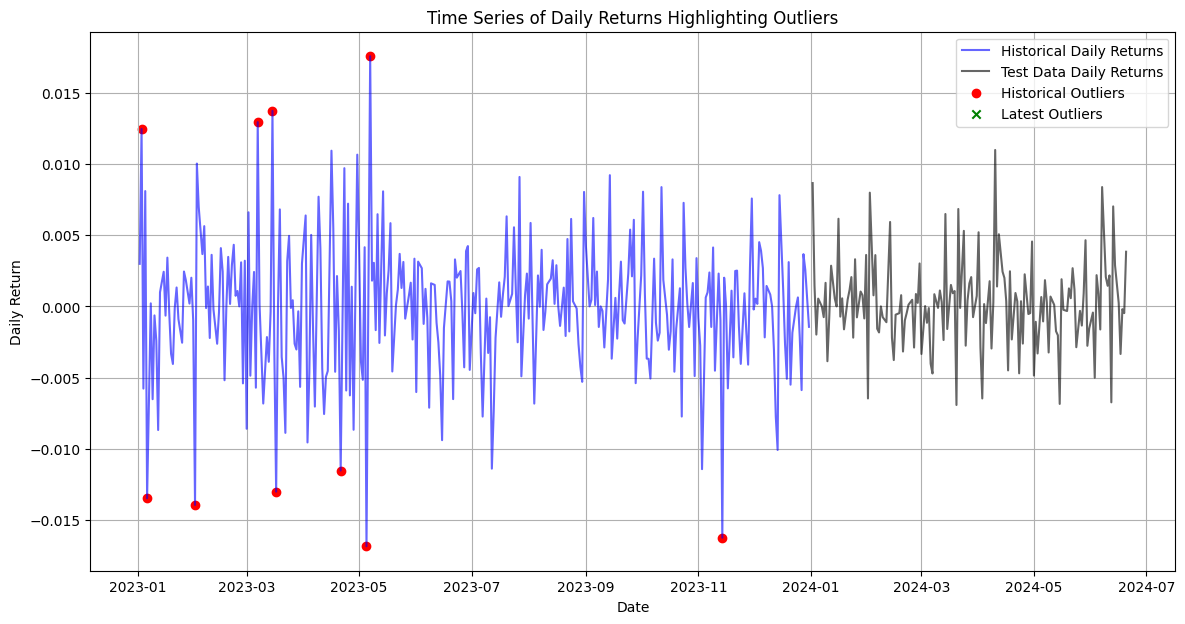

In [8]:
# Function to plot data
def plot_data_with_outliers(historical_df, temp_df, historical_outliers_df, test_outliers_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df['date'], historical_df['daily_return'], label='Historical Daily Returns', color='blue', alpha=0.6)
    plt.plot(temp_df['date'], temp_df['daily_return'], label='Test Data Daily Returns', color='black', alpha=0.6)
    plt.scatter(historical_outliers_df['date'], historical_outliers_df['daily_return'], color='red', label='Historical Outliers')
    plt.scatter(test_outliers_df['date'], test_outliers_df['daily_return'], color='green', label='Latest Outliers', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Time Series of Daily Returns Highlighting Outliers')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot data with outliers
plot_data_with_outliers(historical_df, temp_df, updated_historical_outliers_df, updated_test_outliers_df)